Project during my last year at ENSAE ParisTech (Institut Polytechnique de Paris).

Based on the paper:

'CuMF_SGD: Fast and Scalable Matrix Factorization' by Xiaolong Xie, Wei Tan, Liana L. Fong, Yun Liang

Link to the paper:

[![CuMF_SGD: Fast and Scalable Matrix Factorization](https://img.shields.io/badge/Arxiv-CuMF_SGD:%20Fast%20and%20Scalable%20Matrix%20Factorization-red?style=for-the-badge&logo=arxiv)](https://arxiv.org/abs/1610.05838)



In [1]:
import psutil
import platform
import multiprocessing
import subprocess
import os
import shutil
from tqdm import tqdm
from numba import cuda
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# set pandas display options for better data exploration
pd.set_option('display.max_rows', None) # show all rows
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.width', None) # no width limit
pd.set_option('display.max_colwidth', None) # show full column content

In [3]:
plt.style.use('ggplot')
matplotlib.rcParams['font.family'] = 'mono'

In [4]:
print('current directory is: {}'.format(os.getcwd()))

current directory is: /kaggle/working


# CPU information

In [5]:
def get_comprehensive_cpu_info():
    print("=" * 50)
    print("         CPU INFORMATION")
    print("=" * 50)
    
    # Try to get detailed info using cpuinfo library
    try:
        import cpuinfo
        info = cpuinfo.get_cpu_info()
        has_cpuinfo = True
    except ImportError:
        print("Note: Install 'py-cpuinfo' for more detailed information: pip install py-cpuinfo")
        info = {}
        has_cpuinfo = False
    
    # Basic CPU Information
    print("\n--- Basic Information ---")
    if has_cpuinfo and info.get('brand_raw'):
        print("Name                    = %s" % info.get('brand_raw'))
    else:
        print("Name                    = %s" % platform.processor())
    
    print("Architecture            = %s" % platform.machine())
    print("System                  = %s" % platform.system())
    print("Platform                = %s" % platform.platform())
    
    # Core and Thread Information
    print("\n--- Core/Thread Information ---")
    physical_cores = psutil.cpu_count(logical=False)
    logical_cores = psutil.cpu_count(logical=True)
    print("Physical Cores          = %s" % physical_cores)
    print("Logical Cores           = %s" % logical_cores)
    print("Threads per Core        = %s" % (logical_cores // physical_cores if physical_cores else "N/A"))
    
    # Frequency Information
    print("\n--- Frequency Information ---")
    if has_cpuinfo:
        print("Advertised Frequency    = %s" % info.get('hz_advertised_friendly', 'N/A'))
        print("Actual Frequency        = %s" % info.get('hz_actual_friendly', 'N/A'))
    
    try:
        freq = psutil.cpu_freq()
        if freq:
            print("Current Frequency       = %.2f MHz" % freq.current)
            print("Min Frequency           = %.2f MHz" % freq.min)
            print("Max Frequency           = %.2f MHz" % freq.max)
    except:
        print("Frequency Info          = Not available")
    
    # Cache Information
    print("\n--- Cache Information ---")
    if has_cpuinfo:
        print("L1 Data Cache           = %s" % info.get('l1_data_cache_size', 'N/A'))
        print("L1 Instruction Cache    = %s" % info.get('l1_instruction_cache_size', 'N/A'))
        print("L2 Cache Size           = %s" % info.get('l2_cache_size', 'N/A'))
        print("L3 Cache Size           = %s" % info.get('l3_cache_size', 'N/A'))
    else:
        # Try system-specific methods
        try:
            if platform.system() == "Darwin": # macOS
                l1_cache = subprocess.check_output(['sysctl', '-n', 'hw.l1icachesize']).decode().strip()
                l2_cache = subprocess.check_output(['sysctl', '-n', 'hw.l2cachesize']).decode().strip()
                l3_cache = subprocess.check_output(['sysctl', '-n', 'hw.l3cachesize']).decode().strip()
                print("L1 Cache Size           = %.0f KB" % (int(l1_cache)/1024))
                print("L2 Cache Size           = %.0f KB" % (int(l2_cache)/1024))
                print("L3 Cache Size           = %.0f KB" % (int(l3_cache)/1024))
            elif platform.system() == "Linux":
                with open('/proc/cpuinfo', 'r') as f:
                    for line in f:
                        if 'cache size' in line:
                            print("Cache Size              = %s" % line.split(':')[1].strip())
                            break
        except:
            print("Cache Information       = Not available")
    
    # Vendor and Model Information
    print("\n--- Vendor/Model Information ---")
    if has_cpuinfo:
        print("Vendor ID               = %s" % info.get('vendor_id_raw', 'N/A'))
        print("Family                  = %s" % info.get('family', 'N/A'))
        print("Model                   = %s" % info.get('model', 'N/A'))
        print("Model Name              = %s" % info.get('model_name', 'N/A'))
        print("Stepping                = %s" % info.get('stepping', 'N/A'))
        
    # Memory Information
    print("\n--- Memory Information ---")
    memory = psutil.virtual_memory()
    print("Total Memory            = %.2f GB" % (memory.total / (1024**3)))
    print("Available Memory        = %.2f GB" % (memory.available / (1024**3)))
    print("Used Memory             = %.2f GB" % (memory.used / (1024**3)))
    print("Memory per Core         = %.2f GB" % (memory.total / logical_cores / (1024**3)))
    print("Memory Usage            = %.1f%%" % memory.percent)
    
    # Current Performance
    print("\n--- Current Performance ---")
    print("CPU Usage (1 sec avg)   = %.1f%%" % psutil.cpu_percent(interval=1))
    
    # Per-core usage
    per_core_usage = psutil.cpu_percent(percpu=True, interval=0.1)
    for i, usage in enumerate(per_core_usage):
        print("Core %2d Usage           = %.1f%%" % (i, usage))
    
    # Load Average (Unix-like systems)
    if hasattr(os, 'getloadavg'):
        load1, load5, load15 = os.getloadavg()
        print("Load Average (1 min)    = %.2f" % load1)
        print("Load Average (5 min)    = %.2f" % load5)
        print("Load Average (15 min)   = %.2f" % load15)
    
    # Additional System Information
    print("\n--- Additional Information ---")
    print("Boot Time               = %s" % psutil.boot_time())
    
    # CPU Temperature (if available)
    try:
        temps = psutil.sensors_temperatures()
        if temps:
            for name, entries in temps.items():
                for entry in entries:
                    print("Temperature (%s)       = %.1f°C" % (entry.label or name, entry.current))
    except:
        print("Temperature             = Not available")
    
    print("\n" + "=" * 50)

# Run the comprehensive function
get_comprehensive_cpu_info()

         CPU INFORMATION

--- Basic Information ---
Name                    = Intel(R) Xeon(R) CPU @ 2.00GHz
Architecture            = x86_64
System                  = Linux
Platform                = Linux-6.6.56+-x86_64-with-glibc2.35

--- Core/Thread Information ---
Physical Cores          = 2
Logical Cores           = 4
Threads per Core        = 2

--- Frequency Information ---
Advertised Frequency    = 2.0000 GHz
Actual Frequency        = 2.0001 GHz
Current Frequency       = 2000.14 MHz
Min Frequency           = 0.00 MHz
Max Frequency           = 0.00 MHz

--- Cache Information ---
L1 Data Cache           = 65536
L1 Instruction Cache    = 65536
L2 Cache Size           = 2097152
L3 Cache Size           = 40370176

--- Vendor/Model Information ---
Vendor ID               = GenuineIntel
Family                  = 6
Model                   = 85
Model Name              = N/A
Stepping                = 3

--- Memory Information ---
Total Memory            = 31.35 GB
Available Memory       

# GPU information

In [6]:
!nvidia-smi

Sun Aug  3 09:57:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [8]:
# A plugin for Jupyter Notebook to run CUDA C/C++ code
!pip install nvcc4jupyter

In [9]:
# !nvcc --help

In [10]:
print('current directory is: {}'.format(os.getcwd()))

current directory is: /kaggle/working


In [11]:
gpu = cuda.get_current_device()
print("Name                    = %s" % gpu.name)
print("MaxThreadsPerBlock      = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("MaxBlockDimX            = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("MaxBlockDimY            = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("MaxBlockDimZ            = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("MaxGridDimX             = %s" % str(gpu.MAX_GRID_DIM_X))
print("MaxGridDimY             = %s" % str(gpu.MAX_GRID_DIM_Y))
print("MaxGridDimZ             = %s" % str(gpu.MAX_GRID_DIM_Z))
print("MaxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("AsyncEngineCount        = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("CanMapHostMemory        = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("MultiProcessorCount     = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("WarpSize                = %s" % str(gpu.WARP_SIZE))
print("UnifiedAddressing       = %s" % str(gpu.UNIFIED_ADDRESSING))
print("PciBusID                = %s" % str(gpu.PCI_BUS_ID))
print("PciDeviceID             = %s" % str(gpu.PCI_DEVICE_ID))

Name                    = b'Tesla P100-PCIE-16GB'
MaxThreadsPerBlock      = 1024
MaxBlockDimX            = 1024
MaxBlockDimY            = 1024
MaxBlockDimZ            = 64
MaxGridDimX             = 2147483647
MaxGridDimY             = 65535
MaxGridDimZ             = 65535
MaxSharedMemoryPerBlock = 49152
AsyncEngineCount        = 2
CanMapHostMemory        = 1
MultiProcessorCount     = 56
WarpSize                = 32
UnifiedAddressing       = 1
PciBusID                = 0
PciDeviceID             = 4


# Prepare folders for the differents models

In [12]:
for x in ["model0", "model1", "model21", "model22", "model23", "model24", "model3"]:
    if x not in os.listdir():
        os.mkdir(x)
    else:
        shutil.rmtree(x)
        os.mkdir(x)

In [13]:
print(sorted(os.listdir()))

['.virtual_documents', 'model0', 'model1', 'model21', 'model22', 'model23', 'model24', 'model3']


# The code


In [14]:
cudafile = open(file = "matrixfactorization.txt", mode = "w")

In [15]:
cudafile.write(
r"""

//////////////////////////////////////////////////////////////
// CUDA MATRIX FACTORIZATION WITH TIMING OPTIMIZATIONS
//
// PERFORMANCE OPTIMIZATIONS:
// 1. Pre-initialized random states to avoid expensive curand_init() 
//    calls during timed sections (was causing 400ms+ delays)
// 2. GPU warmup kernels to ensure consistent timing measurements
// 3. Proper synchronization to avoid cold start penalties
//////////////////////////////////////////////////////////////

#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <curand.h>
#include <curand_kernel.h>
#include <cuda_runtime_api.h>
#include <cuda_runtime.h>
#include <cuda_fp16.h>
#include <stdio.h>
#include <unistd.h>
#include <time.h>
#include <sys/time.h>
#include <iostream>
#include <iomanip>
#include <fstream>
#include <algorithm>
#include <cmath>

// CUDA error checking utility function
inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    }
    return err;
}

//////////////////////////////////////////////////////////////
// CUDA KERNELS FOR MATRIX FACTORIZATION
//////////////////////////////////////////////////////////////

/**
 * Model 1.0: Basic implementation with no optimizations
 * Uses shared memory for dot product computation
 * P: row-wise storage, Q: row-wise storage
 */
__global__ void model_1(float alpha, float lambda, int f, int iterations, curandState *state, 
                       float *p, float *q, float *R_r, int *R_u, int *R_v, 
                       int N, int M, int K, int nnz) {
    
    int block = blockIdx.x;
    int thread = threadIdx.x % 32;
    
    __shared__ float tmp_products_array[32];
    
    // Random state is now pre-initialized
    
    int start;
    for (int iter = 0; iter < iterations; iter++) {
        start = curand(&state[block]) % nnz;
        
        // Process f consecutive samples
        for (int i = 0; i < f; i++) {
            int offset = (start + i) % nnz;
            float r = R_r[offset];
            int u = R_u[offset];
            int v = R_v[offset];
            
            float tmp_p1 = p[u*K + thread];
            float tmp_q1 = q[N * thread + v];
            
            // Compute dot product using shared memory
            tmp_products_array[thread] = tmp_p1 * tmp_q1;
            __syncthreads();
            
            float tmp_product = 0;
            for (int thread_i = 0; thread_i < 32; thread_i++) {
                tmp_product += tmp_products_array[thread_i];
            }
            float ruv = r - tmp_product;
            
            // Update P and Q matrices
            // Note: Only works for K = blockDim.x = 32
            p[u*K + thread + 0] = tmp_p1 + alpha*(ruv*tmp_q1 - lambda*tmp_p1);
            q[N * thread + v + 0] = tmp_q1 + alpha*(ruv*tmp_p1 - lambda*tmp_q1);
        }
    }
}

/**
 * Model 2.1: Memory coalescing optimization
 * Improves memory access patterns for better performance
 * P: row-wise storage, Q: column-wise storage
 */
__global__ void model_2_1(float alpha, float lambda, int f, int iterations, curandState *state, 
                         float *p, float *q, float *R_r, int *R_u, int *R_v, 
                         int N, int M, int K, int nnz) {
    
    int block = blockIdx.x;
    int thread = threadIdx.x % 32;
    
    __shared__ float tmp_products_array[32];
    
    // Random state is now pre-initialized
    
    int start;
    for (int iter = 0; iter < iterations; iter++) {
        start = curand(&state[block]) % nnz;
        
        // Process f consecutive samples
        for (int i = 0; i < f; i++) {
            int offset = (start + i) % nnz;
            float r = R_r[offset];
            int u = R_u[offset];
            int v = R_v[offset];
            
            // Pre-compute base indices for better memory coalescing
            int base_p = u*K;
            // For column-wise Q storage: Q[factor][item] = Q[factor + item*K]
            int base_q = v*K;
            
            float tmp_p1 = p[base_p + thread];
            // Correct column-wise access: thread + v*K
            float tmp_q1 = q[thread + base_q];
            
            // Compute dot product using shared memory
            tmp_products_array[thread] = tmp_p1 * tmp_q1;
            __syncthreads();
            
            float tmp_product = 0;
            for (int thread_i = 0; thread_i < 32; thread_i++) {
                tmp_product += tmp_products_array[thread_i];
            }
            
            float ruv = r - tmp_product;
            
            // Update P and Q matrices
            // Note: Only works for K = blockDim.x = 32
            p[base_p + thread + 0] = tmp_p1 + alpha*(ruv*tmp_q1 - lambda*tmp_p1);
            q[thread + base_q + 0] = tmp_q1 + alpha*(ruv*tmp_p1 - lambda*tmp_q1);
        }
    }
}

/**
 * Model 2.2: Warp shuffling optimization
 * Uses warp shuffle operations for faster dot product computation
 * P: row-wise storage, Q: row-wise storage
 */
__global__ void model_2_2(float alpha, float lambda, int f, int iterations, curandState *state, 
                         float *p, float *q, float *R_r, int *R_u, int *R_v, 
                         int N, int M, int K, int nnz) {
    
    int block = blockIdx.x;
    int thread = threadIdx.x % 32;
    
    // Random state is now pre-initialized
    
    int start;
    for (int iter = 0; iter < iterations; iter++) {
        start = curand(&state[block]) % nnz;
        
        // Process f consecutive samples
        for (int i = 0; i < f; i++) {
            int offset = (start + i) % nnz;
            float r = R_r[offset];
            int u = R_u[offset];
            int v = R_v[offset];
            
            int base_p = u*K;
            int base_q = v;
            
            float tmp_p1 = p[u*K + thread];
            float tmp_q1 = q[N * thread + v];
            
            // Compute dot product using warp shuffle operations
            float tmp_product = tmp_p1 * tmp_q1;
            tmp_product += __shfl_down(tmp_product, 16);
            tmp_product += __shfl_down(tmp_product, 8);
            tmp_product += __shfl_down(tmp_product, 4);
            tmp_product += __shfl_down(tmp_product, 2);
            tmp_product += __shfl_down(tmp_product, 1);
            
            // Broadcast result to all threads in warp
            tmp_product = __shfl(tmp_product, 0);
            
            float ruv = r - tmp_product;
            
            // Update P and Q matrices
            // Note: Only works for K = blockDim.x = 32
            p[u*K + thread + 0] = tmp_p1 + alpha*(ruv*tmp_q1 - lambda*tmp_p1);
            q[N * thread + v + 0] = tmp_q1 + alpha*(ruv*tmp_p1 - lambda*tmp_q1);
        }
    }
}

/**
 * Model 2.3: Half precision optimization
 * Uses 16-bit floating point for reduced memory usage
 * P: row-wise storage, Q: row-wise storage
 */
__global__ void model_2_3(float alpha, float lambda, int f, int iterations, curandState *state, 
                         half *p, half *q, float *R_r, int *R_u, int *R_v, 
                         int N, int M, int K, int nnz) {
    
    int block = blockIdx.x;
    int thread = threadIdx.x % 32;
    
    __shared__ float tmp_products_array[32];
    
    // Random state is now pre-initialized
    
    int start;
    for (int iter = 0; iter < iterations; iter++) {
        start = curand(&state[block]) % nnz;
        
        // Process f consecutive samples
        for (int i = 0; i < f; i++) {
            int offset = (start + i) % nnz;
            float r = R_r[offset];
            int u = R_u[offset];
            int v = R_v[offset];
            
            // Convert half precision to float for computation
            float tmp_p1 = __half2float(p[u*K + thread]);
            float tmp_q1 = __half2float(q[N * thread + v]);
            
            // Compute dot product using shared memory
            tmp_products_array[thread] = tmp_p1 * tmp_q1;
            __syncthreads();
            
            float tmp_product = 0;
            for (int thread_i = 0; thread_i < 32; thread_i++) {
                tmp_product += tmp_products_array[thread_i];
            }
            
            float ruv = r - tmp_product;
            
            // Update P and Q matrices, converting back to half precision
            // Note: Only works for K = blockDim.x = 32
            p[u*K + thread + 0] = __float2half(tmp_p1 + alpha*(ruv*tmp_q1 - lambda*tmp_p1));
            q[N * thread + v + 0] = __float2half(tmp_q1 + alpha*(ruv*tmp_p1 - lambda*tmp_q1));
        }
    }
}

/**
 * Model 2.4: Cache optimization
 * Uses read-only cache for rating data access
 * P: row-wise storage, Q: row-wise storage
 */
__global__ void model_2_4(float alpha, float lambda, int f, int iterations, curandState *state, 
                         float *p, float *q, float *R_r, int *R_u, int *R_v, 
                         int N, int M, int K, int nnz) {
    
    int block = blockIdx.x;
    int thread = threadIdx.x % 32;
    
    __shared__ float tmp_products_array[32];
    
    // Random state is now pre-initialized
    
    int start;
    for (int iter = 0; iter < iterations; iter++) {
        start = curand(&state[block]) % nnz;
        
        // Process f consecutive samples
        for (int i = 0; i < f; i++) {
            int offset = (start + i) % nnz;
            
            // Use read-only cache for rating data (__ldg)
            float r = __ldg(&R_r[offset]);
            int u = __ldg(&R_u[offset]);
            int v = __ldg(&R_v[offset]);
            
            float tmp_p1 = p[u*K + thread];
            float tmp_q1 = q[N * thread + v];
            
            // Compute dot product using shared memory
            tmp_products_array[thread] = tmp_p1 * tmp_q1;
            __syncthreads();
            
            float tmp_product = 0;
            for (int thread_i = 0; thread_i < 32; thread_i++) {
                tmp_product += tmp_products_array[thread_i];
            }
            
            float ruv = r - tmp_product;
            
            // Update P and Q matrices
            // Note: Only works for K = blockDim.x = 32
            p[u*K + thread + 0] = tmp_p1 + alpha*(ruv*tmp_q1 - lambda*tmp_p1);
            q[N * thread + v + 0] = tmp_q1 + alpha*(ruv*tmp_p1 - lambda*tmp_q1);
        }
    }
}

/**
 * Model 3: All optimizations combined
 * Combines memory coalescing, warp shuffling, half precision, and cache optimizations
 * P: row-wise storage, Q: column-wise storage
 */
__global__ void model_3(float alpha, float lambda, int f, int iterations, curandState *state, 
                       half *p, half *q, float *R_r, int *R_u, int *R_v, 
                       int N, int M, int K, int nnz) {
    
    int block = blockIdx.x;
    int thread = threadIdx.x % 32;
    
    // Random state is now pre-initialized
    
    int start;
    for (int iter = 0; iter < iterations; iter++) {
        start = curand(&state[block]) % nnz;
        
        // Process f consecutive samples
        for (int i = 0; i < f; i++) {
            int offset = (start + i) % nnz;
            
            // Use read-only cache for rating data
            float r = __ldg(&R_r[offset]);
            int u = __ldg(&R_u[offset]);
            int v = __ldg(&R_v[offset]);
            
            // Pre-compute base indices for memory coalescing
            int base_p = u*K;
            int base_q = v*K;
            
            // Convert half precision to float for computation
            float tmp_p1 = __half2float(p[base_p + thread]);
            // Correct column-wise access for Q: thread + v*K
            float tmp_q1 = __half2float(q[thread + base_q]);
            
            // Compute dot product using warp shuffle operations
            // Note: Only works for K = blockDim.x = 32
            float tmp_product = tmp_p1 * tmp_q1;
            tmp_product += __shfl_down(tmp_product, 16);
            tmp_product += __shfl_down(tmp_product, 8);
            tmp_product += __shfl_down(tmp_product, 4);
            tmp_product += __shfl_down(tmp_product, 2);
            tmp_product += __shfl_down(tmp_product, 1);
            
            // Broadcast result to all threads in warp
            tmp_product = __shfl(tmp_product, 0);
            float ruv = r - tmp_product;
            
            // Update P and Q matrices, converting back to half precision
            // Note: Only works for K = blockDim.x = 32
            p[base_p + thread + 0] = __float2half(tmp_p1 + alpha*(ruv*tmp_q1 - lambda*tmp_p1));
            q[thread + base_q + 0] = __float2half(tmp_q1 + alpha*(ruv*tmp_p1 - lambda*tmp_q1));
        }
    }
}

// Add this new kernel after the existing kernels, before the utility functions
__global__ void init_random_states(curandState *state, int num_blocks) {
    int block = blockIdx.x;
    if (block < num_blocks) {
        curand_init(clock() + block, 0, block, &state[block]);
    }
}

// Add this warmup kernel after the init_random_states kernel
__global__ void warmup_kernel() {
    // Simple computation to warm up the GPU
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    volatile float dummy = sinf((float)idx) * cosf((float)idx);
}

//////////////////////////////////////////////////////////////
// UTILITY FUNCTIONS AND DATA STRUCTURES
//////////////////////////////////////////////////////////////

/**
 * Data structure to hold training data for matrix factorization
 * r: array of rating values
 * u: array of user indices
 * v: array of item indices
 */
struct RTrain {
    float* r;
    int* u;
    int* v;
};

/**
 * Initialize an array with random values between 0 and 1
 * @param array: pointer to array to initialize
 * @param nrows: number of rows
 * @param ncols: number of columns
 */
void randArray(float* array, int nrows, int ncols) {
    for (int row = 0; row < nrows; ++row) {
        for (int col = 0; col < ncols; ++col) {
            array[row * ncols + col] = rand() % 100 / 100.0;
        }
    }
}

/**
 * Display an array in matrix format
 * @param array: pointer to array to display
 * @param nrows: number of rows
 * @param ncols: number of columns
 * @param mode: 'l' for row-wise storage, 'c' for column-wise storage
 */
void printArray(float* array, int nrows, int ncols, char mode) {
    // If the matrix is stored in row-wise format
    if (mode == 'l') {
        for (int row = 0; row < nrows; ++row) {
            for (int col = 0; col < ncols; ++col) {
                std::cout << array[row * ncols + col] << "\t";
            }
            std::cout << "\n";
        }
    }
    // If the matrix is stored in column-wise format
    else if (mode == 'c') {
        for (int row = 0; row < nrows; ++row) {
            for (int col = 0; col < ncols; ++col) {
                std::cout << array[col * nrows + row] << "\t";
            }
            std::cout << "\n";
        }
    }
}

/**
 * Matrix multiplication: R = P * Q
 * P is stored row-wise, Q is stored column-wise, output R is row-wise
 * @param p: pointer to matrix P
 * @param q: pointer to matrix Q
 * @param M: number of rows in P
 * @param N: number of columns in Q
 * @param K: number of columns in P (= number of rows in Q)
 * @return: pointer to result matrix R
 */
float* prodMat(float* p, float* q, int M, int N, int K) {
    float *r = new float[M * N];
    float sumProd = 0;
    
    for (int row = 0; row < M; row++) {
        for (int col = 0; col < N; col++) {
            sumProd = 0;
            for (int k = 0; k < K; k++) {
                sumProd = sumProd + p[row * K + k] * q[k + col * K];
            }
            r[row * N + col] = sumProd;
        }
    }
    return r;
}

/**
 * Matrix multiplication: R = P * Q
 * Both P and Q are stored row-wise, output R is row-wise
 * @param p: pointer to matrix P
 * @param q: pointer to matrix Q
 * @param M: number of rows in P
 * @param N: number of columns in Q
 * @param K: number of columns in P (= number of rows in Q)
 * @return: pointer to result matrix R
 */
float* prodMatRowRow(float* p, float* q, int M, int N, int K) {
    float *r = new float[M * N];
    float sumProd = 0;
    
    for (int row = 0; row < M; row++) {
        for (int col = 0; col < N; col++) {
            sumProd = 0;
            for (int k = 0; k < K; k++) {
                sumProd = sumProd + p[row * K + k] * q[N * k + col];
            }
            r[row * N + col] = sumProd;
        }
    }
    return r;
}

/**
 * Transpose a matrix from row-wise to column-wise storage (or vice versa)
 * @param array: pointer to input matrix
 * @param nrows: number of rows
 * @param ncols: number of columns
 * @return: pointer to transposed matrix
 */
float* transpose(float* array, int nrows, int ncols) {
    float* result = new float[nrows * ncols];
    int result_row, result_col, result_nrows, result_ncols;
    result_nrows = ncols; 
    result_ncols = nrows;
    
    // Row and col correspond to the rows and columns of the input array
    for (int row = 0; row < nrows; row++) {
        for (int col = 0; col < ncols; col++) {
            result_row = col;
            result_col = row;
            result[result_row * result_ncols + result_col] = array[row * ncols + col];
        }
    }
    return result;
}

/**
 * Apply permutation to matrix elements
 * @param array: pointer to input matrix
 * @param nrows: number of rows
 * @param ncols: number of columns
 * @param permutation_row: row permutation array
 * @param permutation_col: column permutation array
 * @param matrix_representation: 'l' for row-wise, 'c' for column-wise
 * @return: pointer to permuted matrix
 */
float* permutation(float* array, int nrows, int ncols, int* permutation_row, int*permutation_col, char matrix_representation) {
    float* array_per = new float[nrows * ncols];
    
    // If matrix is stored row-wise
    if (matrix_representation == 'l') {
        for (int row = 0; row < nrows; row++) {
            for (int col = 0; col < ncols; col++) {
                array_per[row * ncols + col] = array[permutation_row[row] * ncols + permutation_col[col]];
            }
        }
    }
    // If matrix is stored column-wise
    else if (matrix_representation == 'c') {
        for (int row = 0; row < nrows; row++) {
            for (int col = 0; col < ncols; col++) {
                array_per[col * nrows + row] = array[permutation_col[col] * nrows + permutation_row[row]];
            }
        }
    }
    
    return array_per;
}

/**
 * Apply inverse permutation to matrix elements
 * @param array_per: pointer to permuted matrix
 * @param nrows: number of rows
 * @param ncols: number of columns
 * @param permutation_row: row permutation array
 * @param permutation_col: column permutation array
 * @param matrix_representation: 'l' for row-wise, 'c' for column-wise
 * @return: pointer to inverse permuted matrix
 */
float* inversepermutation(float* array_per, int nrows, int ncols, int* permutation_row, int* permutation_col, char matrix_representation) {
    float* array_inv_per = new float[nrows * ncols];
    
    // If matrix is stored row-wise
    if (matrix_representation == 'l') {
        for (int row = 0; row < nrows; row++) {
            for (int col = 0; col < ncols; col++) {
                array_inv_per[permutation_row[row] * ncols + permutation_col[col]] = array_per[row * ncols + col];
            }
        }
    }
    // If matrix is stored column-wise
    else if (matrix_representation == 'c') {
        for (int row = 0; row < nrows; row++) {
            for (int col = 0; col < ncols; col++) {
                array_inv_per[permutation_col[col] * nrows + permutation_row[row]] = array_per[col * nrows + row];
            }
        }
    }
    return array_inv_per;
}

/**
 * Create an array with consecutive integers from 0 to size-1
 * @param size: size of the array
 * @return: pointer to range array
 */
int* range(int size) {
    int* range_arr = new int[size];
    for (int i = 0; i < size; i++) {
        range_arr[i] = i;
    }
    return range_arr;
}

/**
 * Create an array with consecutive floats from 0 to size-1
 * @param size: size of the array
 * @return: pointer to range array
 */
float* rangeFloat(int size) {
    float* range_arr = new float[size];
    for (int i = 0; i < size; i++) {
        range_arr[i] = (float)i;
    }
    return range_arr;
}

/**
 * Create an array filled with a specific value
 * @param size: size of the array
 * @param value: value to fill the array with
 * @return: pointer to filled array
 */
float* repFloat(int size, float value) {
    float* range_arr = new float[size];
    for (int i = 0; i < size; i++) {
        range_arr[i] = value;
    }
    return range_arr;
}

/**
 * Select nnz random cells from r_init to create training data
 * @param r_init: pointer to initial rating matrix
 * @param M: number of users
 * @param N: number of items
 * @param nnz: number of non-zero entries to select
 * @return: RTrain structure containing training data
 */
RTrain randomRTrain(float* r_init, int M, int N, int nnz) {
    float* rand_tab = new float[M * N];
    struct RTrain r_train;
    r_train.r = new float[nnz];
    r_train.u = new int[nnz];
    r_train.v = new int[nnz];
    int count = 0;
    
    // Create an array with nnz ones and (M*N - nnz) zeros
    for (int i = 0; i < M * N; i++) {
        if (i < nnz) {
            rand_tab[i] = 1;
        }
        else {
            rand_tab[i] = 0;
        }
    }
    
    // Randomly shuffle the array
    std::random_shuffle(&rand_tab[0], &rand_tab[M*N]);
    
    // Build the training data arrays
    count = 0;
    for (int i = 0; i < M * N; i++) {
        if (rand_tab[i] == 1) {
            r_train.r[count] = r_init[i];
            r_train.u[count] = (int)i / N;  // User index
            r_train.v[count] = (int)i % N;  // Item index
            count++;
        }
    }
    return r_train;
}

/**
 * CUDA kernel to convert float matrices to half precision
 * @param p: input float P matrix
 * @param q: input float Q matrix
 * @param p_half: output half precision P matrix
 * @param q_half: output half precision Q matrix
 * @param M: number of users
 * @param K: number of latent factors
 * @param N: number of items
 */
__global__ void kernel_float2half(float *p, float *q, half *p_half, half *q_half, int M, int K, int N) {
    for (int i = 0; i < M*K; i++) {
        p_half[i] = __float2half(p[i]);
    }
    for (int i = 0; i < K*N; i++) {
        q_half[i] = __float2half(q[i]);
    }
}

/**
 * CUDA kernel to convert half precision matrices to float
 * @param p_half: input half precision P matrix
 * @param q_half: input half precision Q matrix
 * @param p: output float P matrix
 * @param q: output float Q matrix
 * @param M: number of users
 * @param K: number of latent factors
 * @param N: number of items
 */
__global__ void kernel_half2float(half *p_half, half *q_half, float *p, float *q, int M, int K, int N) {
    for (int i = 0; i < M*K; i++) {
        p[i] = __half2float(p_half[i]);
    }
    for (int i = 0; i < K*N; i++) {
        q[i] = __half2float(q_half[i]);
    }
}

/**
 * Compute L2 distance between two matrices
 * @param R_pred: predicted rating matrix
 * @param R: actual rating matrix
 * @param M: number of users
 * @param N: number of items
 * @return: L2 distance
 */
float distanceL2(float* R_pred, float* R, int M, int N) {
    float dist = 0;
    for (int i = 0; i < M*N; i++) {
        dist = dist + (R_pred[i] - R[i])*(R_pred[i] - R[i]);
    }
    return sqrt(dist);
}

//////////////////////////////////////////////////////////////
// MAIN FUNCTION
//////////////////////////////////////////////////////////////

int main() {
    
    //////////////////////////////////////////////////////////////
    // PROBLEM PARAMETERS
    //////////////////////////////////////////////////////////////
    
    int M = 2048;   // Number of users
    int N = 512;    // Number of items
    int K = 32;     // Number of latent factors
    
    // 80% of cells filled in matrix R
    int nnz = (int)M * N * 0.8;
    
    // Stochastic gradient descent parameters
    float alpha = 0.01;   // Learning rate
    float lambda = 0.001; // Regularization parameter
    
    //////////////////////////////////////////////////////////////
    // MODEL SELECTION FLAGS
    //////////////////////////////////////////////////////////////
    
    bool bool_model_0 = true;    // CPU implementation
    bool bool_model_1 = true;    // GPU basic
    bool bool_model_2_1 = true;  // GPU + memory coalescing
    bool bool_model_2_2 = true;  // GPU + warp shuffling
    bool bool_model_2_3 = true;  // GPU + half precision
    bool bool_model_2_4 = true;  // GPU + cache optimization
    bool bool_model_3 = true;    // GPU + all optimizations
    
    //////////////////////////////////////////////////////////////
    // MATRIX INITIALIZATION
    //////////////////////////////////////////////////////////////
    
    float *h_p, *h_q, *h_r_init;
    h_p = new float[M * K];      // P matrix on host
    h_q = new float[K * N];      // Q matrix on host
    h_r_init = new float[M * N]; // R matrix on host
    struct RTrain h_r_train;     // Training data structure
    
    struct timeval start, end;
    int elapsedtime;
    
    // Initialize random seed
    time_t t;
    srand((unsigned)time(&t));
    
    // Random initialization of P and Q matrices
    randArray(h_p, M, K);
    randArray(h_q, K, N);
    
    // Compute initial R = P * Q
    h_r_init = prodMat(h_p, h_q, M, N, K);
    
    cudaFreeHost(h_p);
    cudaFreeHost(h_q);
    
    //////////////////////////////////////////////////////////////
    // PERMUTATION SETUP FOR RANDOMIZATION
    //////////////////////////////////////////////////////////////
    
    int *permutation_row, *permutation_col, *permutation_identity;
    permutation_identity = range(K);
    permutation_row = range(M);
    permutation_col = range(N);
    
    // Randomly shuffle permutations
    std::random_shuffle(&permutation_row[0], &permutation_row[M]);
    std::random_shuffle(&permutation_col[0], &permutation_col[N]);
    
    // Apply permutation to R matrix
    h_r_init = permutation(h_r_init, M, N, permutation_row, permutation_col, 'l');
    
    // Generate random training matrix
    h_r_train = randomRTrain(h_r_init, M, N, nnz);
    
    //////////////////////////////////////////////////////////////
    // INITIALIZE P AND Q FOR TRAINING
    //////////////////////////////////////////////////////////////
    
    float *p, *q, *q_col;
    p = new float[M * K];      // P matrix for training (always row-wise)
    q = new float[K * N];      // Q matrix for training (row-wise)
    q_col = new float[K * N];  // Q matrix in column-wise format
    randArray(p, M, K);
    randArray(q, K, N);
    
    // Convert Q from row-wise to column-wise for models that need it
    // Row-wise: Q[factor][item] stored as q[factor*N + item]
    // Column-wise: Q[factor][item] stored as q[factor + item*K]
    for (int factor = 0; factor < K; factor++) {
        for (int item = 0; item < N; item++) {
            q_col[factor + item * K] = q[factor * N + item];
        }
    }
    
    // Matrices for inverse permutations (if needed for validation)
    float *inv_perm_p, *inv_perm_q;
    inv_perm_p = new float[M * K];
    inv_perm_q = new float[K * N];
    
    //////////////////////////////////////////////////////////////
    // GPU MEMORY ALLOCATION FOR TRAINING DATA
    //////////////////////////////////////////////////////////////
    
    float *d_R_r;
    int *d_R_u, *d_R_v;
    cudaMalloc((void**)&d_R_r, (size_t)nnz * sizeof(float));
    cudaMalloc((void**)&d_R_u, (size_t)nnz * sizeof(int));
    cudaMalloc((void**)&d_R_v, (size_t)nnz * sizeof(int));
    cudaMemcpy(d_R_r, h_r_train.r, (size_t)nnz * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_R_u, h_r_train.u, (size_t)nnz * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemcpy(d_R_v, h_r_train.v, (size_t)nnz * sizeof(int), cudaMemcpyHostToDevice);
    
    //////////////////////////////////////////////////////////////
    // GPU EXECUTION PARAMETERS
    //////////////////////////////////////////////////////////////
    
    int number_of_blocks = 100;    // Number of parallel workers
    int threads_per_block = 32;    // Warp size = 32
    int iterations = 1000;         // Iterations per worker
    int f = 10;                    // Consecutive samples per iteration
    int loop__ = 30;               // Total training loops
    int loop = loop__ - 1;
    
    int numberofgraphs = 10;       // Number of experimental runs
    
    int updates = number_of_blocks * (iterations * f) * loop;
    
    std::cout << "Number of updates = " << updates << "\n\n";
    
    //////////////////////////////////////////////////////////////
    // MODEL 0: CPU IMPLEMENTATION
    //////////////////////////////////////////////////////////////
    
    if (bool_model_0 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            std::cout << "Version 0 (CPU) – Run " << n+1 << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model0/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model0/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Training loop
            for (int m = 0; m < loop; m++) {
                
                gettimeofday(&start, NULL);
                
                // Perform SGD updates
                for (int j = 0; j < number_of_blocks*(iterations*f); j++) {
                    int offset = rand() % nnz;
                    float r = h_r_train.r[offset];
                    int u = h_r_train.u[offset];
                    int v = h_r_train.v[offset];
                    
                    // Compute dot product
                    float tmp_dotproduct = 0;
                    for (int i = 0; i < K; i++) {
                        tmp_dotproduct = tmp_dotproduct + p[u * K + i] * q[N * i + v];
                    }
                    
                    float ruv = r - tmp_dotproduct;
                    
                    // Update P and Q matrices
                    for (int i = 0; i < K; i++) {
                        float tmp_p = p[u*K + i];
                        float tmp_q = q[N*i + v];
                        p[u*K + i] = tmp_p + alpha*(ruv*tmp_q - lambda*tmp_p);
                        q[N*i + v] = tmp_q + alpha*(ruv*tmp_p - lambda*tmp_q);
                    }
                }
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Calculate current distance
                distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
                
                // Write to output file
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
        }
    }
    
    //////////////////////////////////////////////////////////////
    // MODEL 1: GPU BASIC IMPLEMENTATION
    //////////////////////////////////////////////////////////////
    
    if (bool_model_1 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            std::cout << "Version 1 (GPU Basic) – Run " << n+1 << "\n";
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            // Host matrices
            float *h_p_float, *h_q_float;
            h_p_float = new float[M * K];
            h_q_float = new float[K * N];
            
            h_p_float = p;
            h_q_float = q;
            
            // Device matrices
            float *d_p_float, *d_q_float;
            size_t size_p_float = M * K * sizeof(float);
            size_t size_q_float = K * N * sizeof(float);
            
            cudaMalloc((void**)&d_p_float, size_p_float);
            cudaMalloc((void**)&d_q_float, size_q_float);
            cudaMemcpy(d_p_float, h_p_float, size_p_float, cudaMemcpyHostToDevice);
            cudaMemcpy(d_q_float, h_q_float, size_q_float, cudaMemcpyHostToDevice);
            
            // Random state for CUDA kernels
            curandState *rand_state;
            cudaMallocManaged(&rand_state, sizeof(curandState) * number_of_blocks);
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model1/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model1/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Initialize random states once before training
            init_random_states <<< number_of_blocks, 1 >>> (rand_state, number_of_blocks);
            checkCudaErr(cudaDeviceSynchronize(), "Random state initialization");
            
            // Warm up GPU to ensure consistent timing
            warmup_kernel <<< number_of_blocks, threads_per_block >>> ();
            checkCudaErr(cudaDeviceSynchronize(), "GPU warmup");
            
            // Training loop
            for (int i = 0; i < loop; i++) {
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&start, NULL);
                
                model_1 <<< number_of_blocks, threads_per_block >>> (alpha, lambda, f, iterations, rand_state, d_p_float, d_q_float, d_R_r, d_R_u, d_R_v, N, M, K, nnz);
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Copy results back to host
                cudaMemcpy(h_p_float, d_p_float, size_p_float, cudaMemcpyDeviceToHost);
                cudaMemcpy(h_q_float, d_q_float, size_q_float, cudaMemcpyDeviceToHost);
                
                distance = distanceL2(prodMatRowRow(h_p_float, h_q_float, M, N, K), h_r_init, M, N);
                
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
            
            // Cleanup
            cudaFree(rand_state);
            cudaFreeHost(h_p_float);
            cudaFreeHost(h_q_float);
            cudaFree(d_p_float);
            cudaFree(d_q_float);
        }
    }
    
    //////////////////////////////////////////////////////////////
    // MODEL 2.1: GPU WITH MEMORY COALESCING
    //////////////////////////////////////////////////////////////
    
    if (bool_model_2_1 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            std::cout << "Version 2.1 (GPU + Memory Coalescing) – Run " << n+1 << "\n";
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            // Regenerate column-wise Q for this run
            for (int factor = 0; factor < K; factor++) {
                for (int item = 0; item < N; item++) {
                    q_col[factor + item * K] = q[factor * N + item];
                }
            }
            
            // Host matrices
            float *h_p_float, *h_q_float;
            h_p_float = new float[M * K];
            h_q_float = new float[K * N];
            
            h_p_float = p;
            h_q_float = q_col;  // Use column-wise Q matrix
            
            // Device matrices
            float *d_p_float, *d_q_float;
            size_t size_p_float = M * K * sizeof(float);
            size_t size_q_float = K * N * sizeof(float);
            
            cudaMalloc((void**)&d_p_float, size_p_float);
            cudaMalloc((void**)&d_q_float, size_q_float);
            cudaMemcpy(d_p_float, h_p_float, size_p_float, cudaMemcpyHostToDevice);
            cudaMemcpy(d_q_float, h_q_float, size_q_float, cudaMemcpyHostToDevice);
            
            curandState *rand_state;
            cudaMallocManaged(&rand_state, sizeof(curandState) * number_of_blocks);
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model21/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model21/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Initialize random states once before training
            init_random_states <<< number_of_blocks, 1 >>> (rand_state, number_of_blocks);
            checkCudaErr(cudaDeviceSynchronize(), "Random state initialization");
            
            // Warm up GPU to ensure consistent timing
            warmup_kernel <<< number_of_blocks, threads_per_block >>> ();
            checkCudaErr(cudaDeviceSynchronize(), "GPU warmup");
            
            // Training loop
            for (int i = 0; i < loop; i++) {
                
                gettimeofday(&start, NULL);
                
                model_2_1 <<< number_of_blocks, threads_per_block >>> (alpha, lambda, f, iterations, rand_state, d_p_float, d_q_float, d_R_r, d_R_u, d_R_v, N, M, K, nnz);
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Copy results back to host
                cudaMemcpy(h_p_float, d_p_float, size_p_float, cudaMemcpyDeviceToHost);
                cudaMemcpy(h_q_float, d_q_float, size_q_float, cudaMemcpyDeviceToHost);
                
                distance = distanceL2(prodMat(h_p_float, h_q_float, M, N, K), h_r_init, M, N);
                
                // Write to output file
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
            
            // Cleanup
            cudaFree(rand_state);
            cudaFreeHost(h_p_float);
            cudaFreeHost(h_q_float);
            cudaFree(d_p_float);
            cudaFree(d_q_float);
        }
    }
    
    //////////////////////////////////////////////////////////////
    // MODEL 2.2: GPU WITH WARP SHUFFLING
    //////////////////////////////////////////////////////////////
    
    if (bool_model_2_2 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            std::cout << "Version 2.2 (GPU + Warp Shuffling) – Run " << n+1 << "\n";
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            // Host matrices
            float *h_p_float, *h_q_float;
            h_p_float = new float[M * K];
            h_q_float = new float[K * N];
            
            h_p_float = p;
            h_q_float = q;
            
            // Device matrices
            float *d_p_float, *d_q_float;
            size_t size_p_float = M * K * sizeof(float);
            size_t size_q_float = K * N * sizeof(float);
            
            cudaMalloc((void**)&d_p_float, size_p_float);
            cudaMalloc((void**)&d_q_float, size_q_float);
            cudaMemcpy(d_p_float, h_p_float, size_p_float, cudaMemcpyHostToDevice);
            cudaMemcpy(d_q_float, h_q_float, size_q_float, cudaMemcpyHostToDevice);
            
            curandState *rand_state;
            cudaMallocManaged(&rand_state, sizeof(curandState) * number_of_blocks);
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model22/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model22/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Initialize random states once before training
            init_random_states <<< number_of_blocks, 1 >>> (rand_state, number_of_blocks);
            checkCudaErr(cudaDeviceSynchronize(), "Random state initialization");
            
            // Warm up GPU to ensure consistent timing
            warmup_kernel <<< number_of_blocks, threads_per_block >>> ();
            checkCudaErr(cudaDeviceSynchronize(), "GPU warmup");
            
            // Training loop
            for (int i = 0; i < loop; i++) {
                
                gettimeofday(&start, NULL);
                
                model_2_2 <<< number_of_blocks, threads_per_block >>> (alpha, lambda, f, iterations, rand_state, d_p_float, d_q_float, d_R_r, d_R_u, d_R_v, N, M, K, nnz);
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Copy results back to host
                cudaMemcpy(h_p_float, d_p_float, size_p_float, cudaMemcpyDeviceToHost);
                cudaMemcpy(h_q_float, d_q_float, size_q_float, cudaMemcpyDeviceToHost);
                
                distance = distanceL2(prodMatRowRow(h_p_float, h_q_float, M, N, K), h_r_init, M, N);
                
                // Write to output file
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
            
            // Cleanup
            cudaFree(rand_state);
            cudaFreeHost(h_p_float);
            cudaFreeHost(h_q_float);
            cudaFree(d_p_float);
            cudaFree(d_q_float);
        }
    }
    
    //////////////////////////////////////////////////////////////
    // MODEL 2.3: GPU WITH HALF PRECISION
    //////////////////////////////////////////////////////////////
    
    if (bool_model_2_3 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            std::cout << "Version 2.3 (GPU + Half Precision) – Run " << n+1 << "\n";
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            // Host matrices (both half and float precision)
            half *h_p_half, *h_q_half;
            h_p_half = new half[M * K];
            h_q_half = new half[K * N];
            float *h_p_float, *h_q_float;
            h_p_float = new float[M * K];
            h_q_float = new float[K * N];
            
            h_p_float = p;
            h_q_float = q;
            
            // Device matrices (both half and float precision)
            half *d_p_half, *d_q_half;
            size_t size_p_half = M * K * sizeof(half);
            size_t size_q_half = K * N * sizeof(half);
            float *d_p_float, *d_q_float;
            size_t size_p_float = M * K * sizeof(float);
            size_t size_q_float = K * N * sizeof(float);
            
            cudaMalloc((void**)&d_p_half, size_p_half);
            cudaMalloc((void**)&d_q_half, size_q_half);
            cudaMalloc((void**)&d_p_float, size_p_float);
            cudaMalloc((void**)&d_q_float, size_q_float);
            cudaMemcpy(d_p_float, h_p_float, size_p_float, cudaMemcpyHostToDevice);
            cudaMemcpy(d_q_float, h_q_float, size_q_float, cudaMemcpyHostToDevice);
            
            // Convert float to half precision on GPU
            kernel_float2half <<< 1, 1 >>> (d_p_float, d_q_float, d_p_half, d_q_half, M, K, N);
            
            curandState *rand_state;
            cudaMallocManaged(&rand_state, sizeof(curandState) * number_of_blocks);
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model23/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model23/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Initialize random states once before training
            init_random_states <<< number_of_blocks, 1 >>> (rand_state, number_of_blocks);
            checkCudaErr(cudaDeviceSynchronize(), "Random state initialization");
            
            // Warm up GPU to ensure consistent timing
            warmup_kernel <<< number_of_blocks, threads_per_block >>> ();
            checkCudaErr(cudaDeviceSynchronize(), "GPU warmup");
            
            // Training loop
            for (int i = 0; i < loop; i++) {
                
                gettimeofday(&start, NULL);
                
                model_2_3 <<< number_of_blocks, threads_per_block >>> (alpha, lambda, f, iterations, rand_state, d_p_half, d_q_half, d_R_r, d_R_u, d_R_v, N, M, K, nnz);
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Convert half precision back to float for evaluation
                kernel_half2float <<< 1, 1 >>> (d_p_half, d_q_half, d_p_float, d_q_float, M, K, N);
                
                // Copy results back to host
                cudaMemcpy(h_p_float, d_p_float, size_p_float, cudaMemcpyDeviceToHost);
                cudaMemcpy(h_q_float, d_q_float, size_q_float, cudaMemcpyDeviceToHost);
                
                distance = distanceL2(prodMatRowRow(h_p_float, h_q_float, M, N, K), h_r_init, M, N);
                
                // Write to output file
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
            
            // Cleanup
            cudaFree(rand_state);
            cudaFreeHost(h_p_half);
            cudaFreeHost(h_q_half);
            cudaFreeHost(h_p_float);
            cudaFreeHost(h_q_float);
            cudaFree(d_p_half);
            cudaFree(d_q_half);
            cudaFree(d_p_float);
            cudaFree(d_q_float);
        }
    }
    
    //////////////////////////////////////////////////////////////
    // MODEL 2.4: GPU WITH CACHE OPTIMIZATION
    //////////////////////////////////////////////////////////////
    
    if (bool_model_2_4 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            std::cout << "Version 2.4 (GPU + Cache Optimization) – Run " << n+1 << "\n";
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            // Host matrices
            float *h_p_float, *h_q_float;
            h_p_float = new float[M * K];
            h_q_float = new float[K * N];
            
            h_p_float = p;
            h_q_float = q;
            
            // Device matrices
            float *d_p_float, *d_q_float;
            size_t size_p_float = M * K * sizeof(float);
            size_t size_q_float = K * N * sizeof(float);
            
            cudaMalloc((void**)&d_p_float, size_p_float);
            cudaMalloc((void**)&d_q_float, size_q_float);
            cudaMemcpy(d_p_float, h_p_float, size_p_float, cudaMemcpyHostToDevice);
            cudaMemcpy(d_q_float, h_q_float, size_q_float, cudaMemcpyHostToDevice);
            
            curandState *rand_state;
            cudaMallocManaged(&rand_state, sizeof(curandState) * number_of_blocks);
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model24/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model24/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Initialize random states once before training
            init_random_states <<< number_of_blocks, 1 >>> (rand_state, number_of_blocks);
            checkCudaErr(cudaDeviceSynchronize(), "Random state initialization");
            
            // Warm up GPU to ensure consistent timing
            warmup_kernel <<< number_of_blocks, threads_per_block >>> ();
            checkCudaErr(cudaDeviceSynchronize(), "GPU warmup");
            
            // Training loop
            for (int i = 0; i < loop; i++) {
                
                gettimeofday(&start, NULL);
                
                model_2_4 <<< number_of_blocks, threads_per_block >>> (alpha, lambda, f, iterations, rand_state, d_p_float, d_q_float, d_R_r, d_R_u, d_R_v, N, M, K, nnz);
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Copy results back to host
                cudaMemcpy(h_p_float, d_p_float, size_p_float, cudaMemcpyDeviceToHost);
                cudaMemcpy(h_q_float, d_q_float, size_q_float, cudaMemcpyDeviceToHost);
                
                distance = distanceL2(prodMatRowRow(h_p_float, h_q_float, M, N, K), h_r_init, M, N);
                
                // Write to output file
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
            
            // Cleanup
            cudaFree(rand_state);
            cudaFreeHost(h_p_float);
            cudaFreeHost(h_q_float);
            cudaFree(d_p_float);
            cudaFree(d_q_float);
        }
    }
    
    //////////////////////////////////////////////////////////////
    // MODEL 3: GPU WITH ALL OPTIMIZATIONS
    //////////////////////////////////////////////////////////////
    
    if (bool_model_3 == true) {
        
        for (int n = 0; n < numberofgraphs; n++) {
            
            std::cout << "Version 3 (GPU + All Optimizations) – Run " << n+1 << "\n";
            
            randArray(p, M, K);
            randArray(q, K, N);
            
            // Regenerate column-wise Q for this run
            for (int factor = 0; factor < K; factor++) {
                for (int item = 0; item < N; item++) {
                    q_col[factor + item * K] = q[factor * N + item];
                }
            }
            
            // Host matrices (both half and float precision)
            half *h_p_half, *h_q_half;
            h_p_half = new half[M * K];
            h_q_half = new half[K * N];
            float *h_p_float, *h_q_float;
            h_p_float = new float[M * K];
            h_q_float = new float[K * N];
            
            h_p_float = p;
            h_q_float = q_col;  // Use column-wise Q matrix
            
            // Device matrices (both half and float precision)
            half *d_p_half, *d_q_half;
            size_t size_p_half = M * K * sizeof(half);
            size_t size_q_half = K * N * sizeof(half);
            float *d_p_float, *d_q_float;
            size_t size_p_float = M * K * sizeof(float);
            size_t size_q_float = K * N * sizeof(float);
            
            cudaMalloc((void**)&d_p_half, size_p_half);
            cudaMalloc((void**)&d_q_half, size_q_half);
            cudaMalloc((void**)&d_p_float, size_p_float);
            cudaMalloc((void**)&d_q_float, size_q_float);
            cudaMemcpy(d_p_float, h_p_float, size_p_float, cudaMemcpyHostToDevice);
            cudaMemcpy(d_q_float, h_q_float, size_q_float, cudaMemcpyHostToDevice);
            
            // Convert float to half precision on GPU
            kernel_float2half <<< 1, 1 >>> (d_p_float, d_q_float, d_p_half, d_q_half, M, K, N);
            
            curandState *rand_state;
            cudaMallocManaged(&rand_state, sizeof(curandState) * number_of_blocks);
            
            // Create output files
            char name[32];
            snprintf(name, sizeof(name), "model3/file_%d.txt", n);
            std::ofstream myfile(name);
            char name1[32];
            snprintf(name1, sizeof(name1), "model3/file_%d(updates).txt", n);
            std::ofstream myfile1(name1);
            
            myfile << "time" << "\t" << "distance" << "\n";
            // myfile1 << "updates per second" << "\n";
            
            float distance;
            float modeltime = 0;
            
            // Initial distance calculation
            distance = distanceL2(prodMatRowRow(p, q, M, N, K), h_r_init, M, N);
            myfile << modeltime << "\t" << distance << "\n";
            std::cout << "Initial distance: " << std::fixed << std::setprecision(0) << distance << "\n";
            
            // Initialize random states once before training
            init_random_states <<< number_of_blocks, 1 >>> (rand_state, number_of_blocks);
            checkCudaErr(cudaDeviceSynchronize(), "Random state initialization");
            
            // Warm up GPU to ensure consistent timing
            warmup_kernel <<< number_of_blocks, threads_per_block >>> ();
            checkCudaErr(cudaDeviceSynchronize(), "GPU warmup");
            
            // Training loop
            for (int i = 0; i < loop; i++) {
                
                gettimeofday(&start, NULL);
                
                model_3 <<< number_of_blocks, threads_per_block >>> (alpha, lambda, f, iterations, rand_state, d_p_half, d_q_half, d_R_r, d_R_u, d_R_v, N, M, K, nnz);
                
                checkCudaErr(cudaDeviceSynchronize(), "Synchronization");
                
                gettimeofday(&end, NULL);
                
                elapsedtime = (end.tv_sec - start.tv_sec) * 1000 + (end.tv_usec - start.tv_usec)/1000;
                modeltime = modeltime + elapsedtime;
                
                // Convert half precision back to float for evaluation
                kernel_half2float <<< 1, 1 >>> (d_p_half, d_q_half, d_p_float, d_q_float, M, K, N);
                
                // Copy results back to host
                cudaMemcpy(h_p_float, d_p_float, size_p_float, cudaMemcpyDeviceToHost);
                cudaMemcpy(h_q_float, d_q_float, size_q_float, cudaMemcpyDeviceToHost);
                
                distance = distanceL2(prodMat(h_p_float, h_q_float, M, N, K), h_r_init, M, N);
                
                // Write to output file
                myfile << modeltime << "\t" << distance << "\n";
            }
            
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << modeltime << " milliseconds" << "\n";
            float updpersec = updates / (modeltime/1000.0);
            std::cout << std::fixed << std::setprecision(0) << std::setw(10) << std::left << updpersec << " updates per second" << "\n\n";
            myfile1 << std::fixed << std::setprecision(0) << updpersec << "\n";
            
            myfile.close();
            myfile1.close();
            
            // Cleanup
            cudaFree(rand_state);
            cudaFreeHost(h_p_half);
            cudaFreeHost(h_q_half);
            cudaFreeHost(h_p_float);
            cudaFreeHost(h_q_float);
            cudaFree(d_p_half);
            cudaFree(d_q_half);
            cudaFree(d_p_float);
            cudaFree(d_q_float);
        }
    }
    
    //////////////////////////////////////////////////////////////
    // CLEANUP AND PROGRAM END
    //////////////////////////////////////////////////////////////
    
    // Free host memory
    delete[] p;
    delete[] q;
    delete[] q_col;
    delete[] inv_perm_p;
    delete[] inv_perm_q;
    delete[] h_r_train.r;
    delete[] h_r_train.u;
    delete[] h_r_train.v;
    delete[] permutation_row;
    delete[] permutation_col;
    delete[] permutation_identity;
    
    // Free GPU memory for training data
    cudaFree(d_R_r);
    cudaFree(d_R_u);
    cudaFree(d_R_v);
    
    std::cout << "Program finished successfully.\n";
    
    return 0;
}

"""
)

62404

In [16]:
cudafile.close()

In [17]:
# renaming the file to change the extension
thisfile = "matrixfactorization.txt"
base = os.path.splitext(thisfile)[0]
os.rename(thisfile, base + ".cu")

# Running the code

In [18]:
!nvcc matrixfactorization.cu --disable-warnings --run

Number of updates = 29000000

Version 0 (CPU) – Run 1
Initial distance: 1807
13281      milliseconds
2183570    updates per second

Version 0 (CPU) – Run 2
Initial distance: 1805
13109      milliseconds
2212220    updates per second

Version 0 (CPU) – Run 3
Initial distance: 1824
13104      milliseconds
2213065    updates per second

Version 0 (CPU) – Run 4
Initial distance: 1795
13210      milliseconds
2195306    updates per second

Version 0 (CPU) – Run 5
Initial distance: 1820
13266      milliseconds
2186040    updates per second

Version 0 (CPU) – Run 6
Initial distance: 1797
13076      milliseconds
2217804    updates per second

Version 0 (CPU) – Run 7
Initial distance: 1829
13161      milliseconds
2203480    updates per second

Version 0 (CPU) – Run 8
Initial distance: 1803
13452      milliseconds
2155813    updates per second

Version 0 (CPU) – Run 9
Initial distance: 1803
13180      milliseconds
2200304    updates per second

Version 0 (CPU) – Run 10
Initial distance: 1808
1308

# Data for the graphs

In [19]:
dictionary = {
    "model0"  : "CPU",
    "model1"  : "GPU with no optimization",
    "model21" : "GPU with memory coalescing",
    "model22" : "GPU with warp shuffling",
    "model23" : "GPU with half precision",
    "model24" : "GPU with cache",
    "model3"  : "GPU with all the optimizations",
}

In [20]:
r = 0
data_frames = [] # Collect dataframes for efficient concatenation
for word in ["model0", "model1", "model21", "model22", "model23", "model24", "model3"]:
    files = [x for x in os.listdir(word) if "file_" in x and "updates" not in x]
    print()
    print(word.ljust(7), '–', ', '.join(sorted(files)))
    for x in files:
        r += 1
        file_path = os.path.join(word, x) # Use os.path.join for safer path construction
        data_ = pd.read_csv(file_path, sep="\t")
        data_["ID"] = r
        data_["model"] = dictionary[word]
        data_frames.append(data_)

# Concatenate all at once for better performance (df.append is deprecated)
data = pd.concat(data_frames, ignore_index=True) if data_frames else pd.DataFrame()


model0  – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt

model1  – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt

model21 – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt

model22 – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt

model23 – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt

model24 – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt

model3  – file_0.txt, file_1.txt, file_2.txt, file_3.txt, file_4.txt, file_5.txt, file_6.txt, file_7.txt, file_8.txt, file_9.txt


In [21]:
head = data.head(n = 8)

print(head)

   time  distance  ID model
0     0  1819.940   1   CPU
1   460   501.621   1   CPU
2   915   481.411   1   CPU
3  1373   461.516   1   CPU
4  1828   428.693   1   CPU
5  2287   386.750   1   CPU
6  2739   342.712   1   CPU
7  3199   299.826   1   CPU


In [22]:
sample = data.sample(n = 16)

print(sample)

      time   distance  ID                           model
807    216    69.0483  27      GPU with memory coalescing
21    9635    33.1570   1                             CPU
842     16   485.1970  29      GPU with memory coalescing
516     54   361.2830  18        GPU with no optimization
430     90   205.6510  15        GPU with no optimization
1714    40   440.1120  58                  GPU with cache
818     64   276.7410  28      GPU with memory coalescing
1951     7   507.2940  66  GPU with all the optimizations
2032   154    62.1679  68  GPU with all the optimizations
710    160    46.0589  24      GPU with memory coalescing
1076   209    41.1295  36         GPU with warp shuffling
1360   100   218.0900  46         GPU with half precision
1249   190    67.8513  42         GPU with half precision
600      0  1792.8900  21      GPU with memory coalescing
1366   161   104.8230  46         GPU with half precision
965     40   401.6110  33         GPU with warp shuffling


In [23]:
grouped = data.groupby(['ID', 'model']).apply(
    lambda x: pd.Series({'count': x.shape[0]}),
    include_groups=False,
).reset_index()

print(grouped)

    ID                           model  count
0    1                             CPU     30
1    2                             CPU     30
2    3                             CPU     30
3    4                             CPU     30
4    5                             CPU     30
5    6                             CPU     30
6    7                             CPU     30
7    8                             CPU     30
8    9                             CPU     30
9   10                             CPU     30
10  11        GPU with no optimization     30
11  12        GPU with no optimization     30
12  13        GPU with no optimization     30
13  14        GPU with no optimization     30
14  15        GPU with no optimization     30
15  16        GPU with no optimization     30
16  17        GPU with no optimization     30
17  18        GPU with no optimization     30
18  19        GPU with no optimization     30
19  20        GPU with no optimization     30
20  21      GPU with memory coales

In [24]:
data.to_csv("data.txt", sep = "\t", index = False)

# Figures

In [25]:
# Assuming the data file is named 'data.txt' and is tab-separated with headers
data = pd.read_csv("data.txt", sep="\t")

In [26]:
# Function to add LOWESS smoothing lines with colors from palette
def add_lowess_smoothing(ax, data, x_col, y_col, group_col, palette, span=0.1):
    groups = data[group_col].unique()
    for group in groups:
        subset = data[data[group_col] == group]
        smoothed = lowess(subset[y_col], subset[x_col], frac=span)
        color = palette.get(group, 'black') # Use model-specific color from palette
        ax.plot(smoothed[:, 0], smoothed[:, 1], linewidth=0.7, label=f"{group} smooth", color=color)

In [27]:
fraction = 0.75

distance = data.groupby(
        by = ['model', 'ID']
    ).apply(
        lambda x: x.sort_values(by = 'time', ascending = True).iloc[-1]['distance'],
        include_groups = False,
    ).quantile(fraction)

In [28]:
# Function to find the first time (aggregated with the mean accross different runs)
def min_time_to_distance(df, distance):
    subset = df.copy(deep = True)

    subset = subset[
        (subset['distance'] < distance)
    ].groupby(
        by = 'ID'
    ).apply(
        lambda x: x.sort_values(by = 'distance', ascending = False).iloc[0],
        include_groups = False,
    )
    
    if subset.empty:
        return np.nan # Use NaN if no data point reaches <= distance
    return subset['time'].mean()

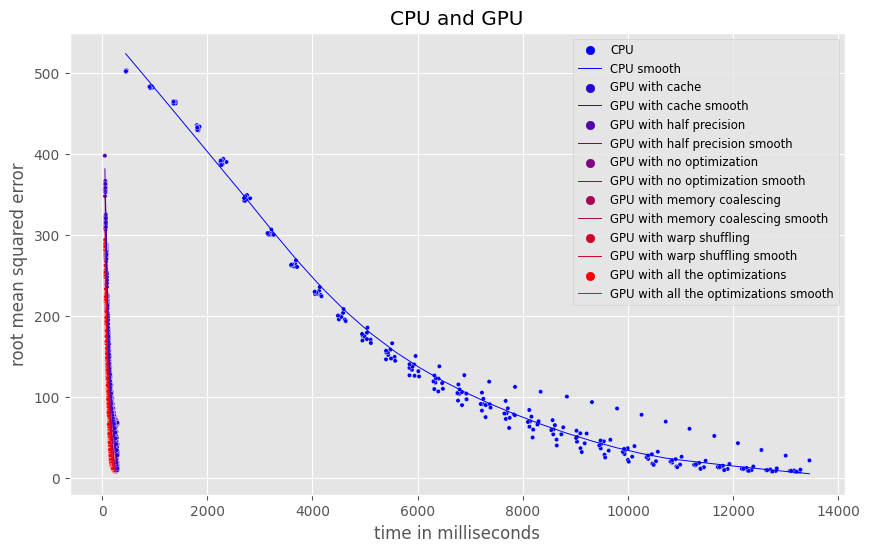

In [29]:
# First plot: Models including "CPU" with time > minimum_time
minimum_time = 50
filtered_data2 = data[(data["time"] > minimum_time)].copy() # Copy to avoid modifying original

# Calculate fastest time to distance <= the distance we calculated previoulsy per model
fastest_times = filtered_data2.groupby('model').apply(lambda x: min_time_to_distance(x, distance), include_groups=False)

# Mean across models (ignoring NaNs) - kept for potential use, but not for palette
mean_fastest_time = fastest_times.mean(skipna=True)

# Rank the fastest_times for equal spacing in the color palette
# Use 'average' method for ties; ranks start from 1
ranks = fastest_times.rank(method='average')
max_rank = ranks.max()
# Normalize ranks to [0,1] with equal spacing: (rank - 1) / (max_rank - 1)
# If max_rank == 1 (all same), default to 0.5
norm_ranks = (ranks - 1) / (max_rank - 1) if max_rank > 1 else pd.Series(0.5, index=fastest_times.index)

# Define color fade from #0392cf to #ffc2cd
color_start = 'red'
color_end = 'blue'
cmap = LinearSegmentedColormap.from_list('fade', [color_start, color_end])

# Create a palette for models based on normalized ranks
palette = {model: cmap(norm_rank) for model, norm_rank in norm_ranks.items()}

# Order models from slowest (highest fastest_time) to fastest (lowest fastest_time)
sorted_models = fastest_times.sort_values(ascending=False).index.tolist()

# Set 'model' as ordered categorical for legend ordering
filtered_data2['model'] = pd.Categorical(filtered_data2['model'], categories=sorted_models, ordered=True)

# Plot with color fade applied to points and LOWESS curves via palette
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data2, x="time", y="distance", hue="model", s=10, palette=palette)
add_lowess_smoothing(plt.gca(), filtered_data2, "time", "distance", "model", palette, 0.4)
plt.xlabel("time in milliseconds")
plt.ylabel("root mean squared error")
plt.title("CPU and GPU")

# Get handles and labels, then sort legend by the ordered categories
handles, labels = plt.gca().get_legend_handles_labels()
# Sort based on the order in sorted_models
order = {label: i for i, label in enumerate(sorted_models)}
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: order.get(x[1].replace(" smooth", ""), len(order)))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
plt.legend(sorted_handles, sorted_labels, fontsize='small')

plt.grid(True)
plt.show()

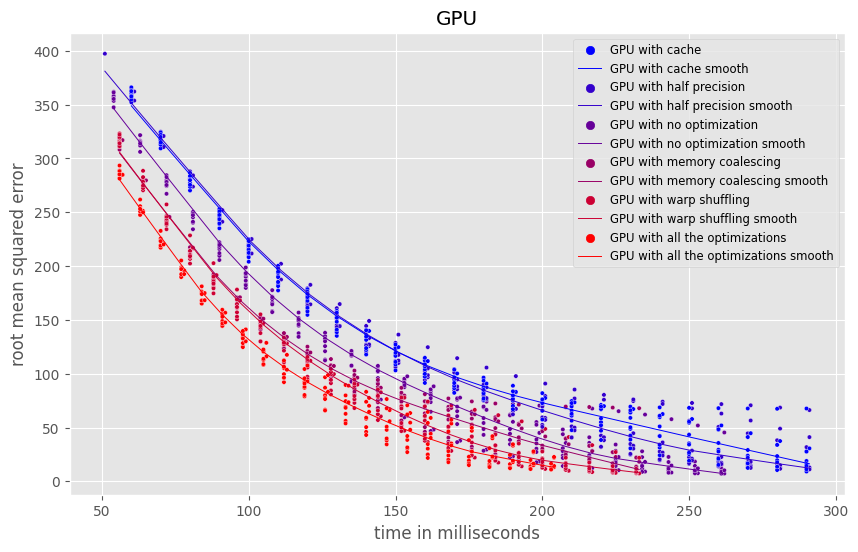

In [30]:
# Second plot: Models excluding "CPU" with time > minimum_time
minimum_time = 50
filtered_data2 = data[(data["model"] != "CPU") & (data["time"] > minimum_time)].copy() # Copy to avoid modifying original

# Calculate fastest time to distance <= the distance we calculated previoulsy per model
fastest_times = filtered_data2.groupby('model').apply(lambda x: min_time_to_distance(x, distance), include_groups=False)

# Mean across models (ignoring NaNs) - kept for potential use, but not for palette
mean_fastest_time = fastest_times.mean(skipna=True)

# Rank the fastest_times for equal spacing in the color palette
# Use 'average' method for ties; ranks start from 1
ranks = fastest_times.rank(method='average')
max_rank = ranks.max()
# Normalize ranks to [0,1] with equal spacing: (rank - 1) / (max_rank - 1)
# If max_rank == 1 (all same), default to 0.5
norm_ranks = (ranks - 1) / (max_rank - 1) if max_rank > 1 else pd.Series(0.5, index=fastest_times.index)

# Define color fade from #0392cf to #ffc2cd
color_start = 'red'
color_end = 'blue'
cmap = LinearSegmentedColormap.from_list('fade', [color_start, color_end])

# Create a palette for models based on normalized ranks
palette = {model: cmap(norm_rank) for model, norm_rank in norm_ranks.items()}

# Order models from slowest (highest fastest_time) to fastest (lowest fastest_time)
sorted_models = fastest_times.sort_values(ascending=False).index.tolist()

# Set 'model' as ordered categorical for legend ordering
filtered_data2['model'] = pd.Categorical(filtered_data2['model'], categories=sorted_models, ordered=True)

# Plot with color fade applied to points and LOWESS curves via palette
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data2, x="time", y="distance", hue="model", s=10, palette=palette)
add_lowess_smoothing(plt.gca(), filtered_data2, "time", "distance", "model", palette, 0.4)
plt.xlabel("time in milliseconds")
plt.ylabel("root mean squared error")
plt.title("GPU")

# Get handles and labels, then sort legend by the ordered categories
handles, labels = plt.gca().get_legend_handles_labels()
# Sort based on the order in sorted_models
order = {label: i for i, label in enumerate(sorted_models)}
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: order.get(x[1].replace(" smooth", ""), len(order)))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
plt.legend(sorted_handles, sorted_labels, fontsize='small')

plt.grid(True)
plt.show()